# importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
with open("C:/Aditya/Poker/Poker_2/poker_3q.pkl",'rb') as to_read:
  gamble2 = pickle.load(to_read)

print(gamble2.shape)
gamble2.columns

(1415, 19)


Index(['player_id', 'age', 'gender', 'deposit_amount', 'stop-loss/win-goal',
       'time_limit', 'country', 'income_level', 'gambling_experience', 'date',
       'session_count', 'total_duration', 'hands_played', 'buy_in_amount_$',
       'cash_out_amount_$', 'net_result_$', 'late_night_hours', 'game_type',
       'stake_level'],
      dtype='object')

 Basic information about the data-columns

In [3]:
gamble2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   player_id            1415 non-null   int64         
 1   age                  1415 non-null   int64         
 2   gender               1415 non-null   int64         
 3   deposit_amount       1415 non-null   int64         
 4   stop-loss/win-goal   1415 non-null   int64         
 5   time_limit           1415 non-null   int64         
 6   country              1415 non-null   object        
 7   income_level         1415 non-null   int64         
 8   gambling_experience  1415 non-null   int64         
 9   date                 1415 non-null   datetime64[ns]
 10  session_count        1415 non-null   int64         
 11  total_duration       1415 non-null   int64         
 12  hands_played         1415 non-null   int64         
 13  buy_in_amount_$      1415 non-nul

In [4]:
poker_set = gamble2.copy()
poker_set.shape

(1415, 19)

# Adding calculated columns 


In [ ]:
# self_exclusive function with combination of time/money conditions
def self_exclusive(row):
    
    if (row['stop-loss/win-goal'] == 1 ) and (row['time_limit'] == 1):
        return 3
    elif row['stop-loss/win-goal'] == 1:
        return 1
    elif row['time_limit'] == 1:
        return 2
    
    else:
        return 0

poker_set["selfexc_history"] = poker_set.apply(self_exclusive,axis=1)

# convertions of gambling experience to year
poker_set["gambling_experience"] = poker_set["gambling_experience"] // 12 
# Total duration convertion to hour 
poker_set["duration_hour"] = poker_set["total_duration"] // 60 
# session intensity column which determine session played at each hour 
poker_set["session_intensity"] = poker_set["duration_hour"] // poker_set["session_count"]
# hands played per session
poker_set["avg_hands/session"] = poker_set["hands_played"] // poker_set["session_count"]
# avg hands played per session in total
poker_set["avg_total_hands/session"] = np.ceil(poker_set.groupby('player_id')["avg_hands/session"].transform("mean")).astype(int)
# sum of net result of total losses and wins
poker_set["sum_net_result"] = np.ceil(poker_set.groupby("player_id")["net_result_$"].transform('sum')).astype(int)
# avg of buy in amount which the player took in with him
poker_set["avg_buyin_amount"] = np.ceil(poker_set.groupby("player_id")["buy_in_amount_$"].transform('mean')).astype(int)
# avg late night session for all the  players
poker_set["avg_latenight_hrs"] = np.ceil(poker_set.groupby("player_id")["late_night_hours"].transform('mean')).astype(int)
# avg sessions played by the player per hour 
poker_set["avg_session_intensity"] = np.ceil(poker_set.groupby('player_id')["session_intensity"].transform('mean')).astype(int)
# avg hour spend by each player 
poker_set["avg_duration_hour"] = np.ceil(poker_set.groupby('player_id')["duration_hour"].transform('mean')).astype(int)

In [ ]:
# check for next day game level 
poker_set["nextday_stake"] = poker_set.groupby("player_id")["stake_level"].shift(-1)
# check for next day session count
poker_set["nextday_session"] = poker_set.groupby("player_id")["session_count"].shift(-1)

# function to determine  the no.of losses each player faced each day when he/she faced the losses 
def chase_loss_flag(row):
    if row['net_result_$'] < 0:
        if row["nextday_session"] > row["session_count"]:
            return 1
        elif row["nextday_stake"] >= row["stake_level"]:
            return 1
        elif row["nextday_session"] > row["session_count"] and (row["nextday_stake"] >= row["stake_level"]) :
            return 1  
    return 0


poker_set["chase_losses"] = poker_set.apply(chase_loss_flag, axis=1) 
chaseloss_count = poker_set[poker_set["chase_losses"] == 1].groupby('player_id').size().reset_index() # creating an column for ounting losses
poker_set = poker_set.merge(chaseloss_count, on='player_id', how='left')
poker_set = poker_set.rename(columns={0:'chaseloss_count'})

# calculated mean loss for all the player for comparision
mean_loss = poker_set["chaseloss_count"].mean()
# function for classifiction  of the losse players 
def chase_mean_diff(row):
    if row["chaseloss_count"] < mean_loss - 1.0:
        return 1
    elif (row["chaseloss_count"] >= mean_loss - 1) and (row["chaseloss_count"] <= mean_loss + 1):
        return 2
    elif row["chaseloss_count"] > mean_loss + 1:
        return 3
    
poker_set["chase_addict"] = poker_set.apply(chase_mean_diff,axis=1)

# sum of deposite for the whole month
month_deposit = poker_set["buy_in_amount_$"].sum()
# deposit percentage for each player
poker_set["deposit_per"] = (((poker_set.groupby("player_id")["buy_in_amount_$"].transform("sum")) / month_deposit) * 100).round(2)
# no.of counts having losses
poker_set["negative_count"] = poker_set.groupby('player_id')["net_result_$"].transform(lambda x: (x <= 0).sum())
# no. of counts having winning
poker_set["positive_count"] = poker_set.groupby("player_id")["net_result_$"].transform(lambda x: (x > 0).sum())
# no.of rounds played by each player
poker_set["total_rounds"] = poker_set["negative_count"] + poker_set["positive_count"]
# loss percentage
poker_set["total_loss%"] = ((poker_set["negative_count"] / poker_set["total_rounds"]) * 100).round(2)

# function for identifying different income level
def diff_income_level(row):
    if row["income_level"] == 0:
        return 0
    elif row["income_level"] < 4:
        return 1
    elif 4 >= row["income_level"] <= 6:
        return 2
    else:
        return 3

# function for detecting spikes in the amount deposit    
def spike_dance(row):
    if (row["total_loss%"] >= 60) & (row["income_levels"] == 3):
        return 3
    elif (50 <= row["total_loss%"]  <= 60) & ((row["income_levels"] == 2) | (row["income_levels"] == 3)):
        return 2
    else:
        return 1
    
    
poker_set["income_levels"] = poker_set.apply(diff_income_level, axis=1)
poker_set["affluent_loss_prone"] = poker_set.apply(spike_dance,axis=1)


In [ ]:
# differentiate age groups 
conditions = [
    
    (poker_set['age'].between(18, 25)),
    (poker_set['age'].between(26, 31)),
    (poker_set['age'].between(32,40)),
    (poker_set['age'].between(41, 55)),
    (poker_set['age'] > 55)
]
choices = [ 1, 2, 3, 4, 5]
poker_set['age_class'] = np.select(conditions, choices, default=0)

# creating clumns for identifying most age group playing poker with respect to the whole month

mean_session = poker_set["session_count"].mean().astype(int) # mean=2 - highest=7 2-7 = threshold value

def session_range(row):
    if row["session_count"] >= mean_session:
        return row["session_count"]
    else:
        return 0
    
poker_set["session_range"] = poker_set.apply(session_range,axis=1).astype(int)

drop_zeros = poker_set[poker_set["session_range"] !=0 ]

threshold_value = np.percentile(drop_zeros["session_range"],75).astype(int)


poker_set["mean_mask"] = np.ceil(poker_set.groupby("player_id")["session_count"].transform("mean")).astype(int)

def session_in_age(row):

    if row["mean_mask"] > threshold_value:
        return 3
    elif row["mean_mask"] == threshold_value:
        return 2
    else:
        return 1
# storing the age classification in to 'age classification' column
poker_set["age_classification"] = poker_set.apply(session_in_age,axis=1)

In [ ]:
# getting deposit spikes for the prev 4 days
poker_set["prev_day_deposit"] = poker_set.groupby("player_id")["buy_in_amount_$"].shift(1).rolling(window =4,min_periods = 1).mean()
poker_set["prev_day_time"] = poker_set.groupby("player_id")["session_intensity"].shift(1).rolling(window = 4, min_periods = 1).mean()

def spike_chase(row):
    if row["prev_day_deposit"] < row["buy_in_amount_$"]:
        return 1
    if (row["prev_day_deposit"] < row["buy_in_amount_$"]) and (row["prev_day_time"] < row["session_intensity"]):
        return 1    
    return 0

poker_set["spike_detect"] = poker_set.apply(spike_chase,axis=1)
spike_inflation = poker_set[poker_set["spike_detect"] == 1].groupby('player_id').size().reset_index()
poker_set = poker_set.merge(spike_inflation, on='player_id', how='left')
poker_set = poker_set.rename(columns={0:'spike_inflation'})

# Internal calculation
poker_set["negative_count"] = poker_set.groupby('player_id')["net_result_$"].transform(lambda x: (x < 0).sum())
poker_set["positive_count"] = poker_set.groupby("player_id")["net_result_$"].transform(lambda x: (x > 0).sum())
poker_set["total_rounds"] = poker_set["negative_count"] + poker_set["positive_count"]
poker_set["spike_inflation_%"] = ((poker_set["spike_inflation"]/poker_set["total_rounds"]) * 100).round(2)

def diff_income_level(row):
    if row["income_level"] == 0:
        return 0
    elif row["income_level"] < 4:
        return 1
    elif 4 >= row["income_level"] <= 6:
        return 2
    else:
        return 3
    
def expereince_jump(row):
    if (row["gambling_experience"] <= 2 ) & (row["spike_inflation_%"]> 60):
        return 3
    elif (50 <= row["spike_inflation_%"]  <= 60) & (row["gambling_experience"] <= 2):
        return 2
    else:
        return 0

poker_set["income_levels"] = poker_set.apply(diff_income_level, axis=1)
poker_set["impulsive_behaviour_flag"] = poker_set.apply(expereince_jump, axis=1)
poker_set["sum_latenight_hrs"] = poker_set.groupby("player_id")["late_night_hours"].transform('sum')
poker_set["sum_session_count"] = poker_set.groupby("player_id")["session_count"].transform('sum')

poker_set["latenight_session%"] = ((poker_set["sum_latenight_hrs"] / poker_set["sum_session_count"]) * 100).round(2)

# Filtering of columns into different files 

In [9]:
print(poker_set.shape)
poker_set.columns

(1415, 54)


Index(['player_id', 'age', 'gender', 'deposit_amount', 'stop-loss/win-goal',
       'time_limit', 'country', 'income_level', 'gambling_experience', 'date',
       'session_count', 'total_duration', 'hands_played', 'buy_in_amount_$',
       'cash_out_amount_$', 'net_result_$', 'late_night_hours', 'game_type',
       'stake_level', 'selfexc_history', 'duration_hour', 'session_intensity',
       'avg_hands/session', 'avg_total_hands/session', 'sum_net_result',
       'avg_buyin_amount', 'avg_latenight_hrs', 'avg_session_intensity',
       'avg_duration_hour', 'nextday_stake', 'nextday_session', 'chase_losses',
       'chaseloss_count', 'chase_addict', 'deposit_per', 'negative_count',
       'positive_count', 'total_rounds', 'total_loss%', 'income_levels',
       'affluent_loss_prone', 'age_class', 'session_range', 'mean_mask',
       'age_classification', 'prev_day_deposit', 'prev_day_time',
       'spike_detect', 'spike_inflation', 'spike_inflation_%',
       'impulsive_behaviour_flag', 

In [9]:
poker_set2 = poker_set.copy()
poker_set2.drop(columns={'stop-loss/win-goal','time_limit','income_level', 'gambling_experience', 'date','session_intensity','duration_hour',
                            'session_count', 'total_duration', 'hands_played', 'buy_in_amount_$','cash_out_amount_$', 'net_result_$', 'late_night_hours', 'game_type',
                            'stake_level','affluent_loss_prone','chase_addict','impulsive_behaviour_flag','spike_inflation_%','spike_detect','age_classification',
                            'selfexc_history','avg_hands/session','avg_latenight_hrs','nextday_stake','nextday_session','chase_losses','deposit_per','negative_count',
                            'positive_count','prev_day_deposit','prev_day_time','spike_detect','session_range'},axis = 1, inplace = True)


In [11]:
poker_Table2 = poker_set2.groupby('player_id')[['age','gender','country','deposit_amount', 'avg_total_hands/session',
       'sum_net_result', 'avg_buyin_amount', 'avg_session_intensity','avg_duration_hour', 'chaseloss_count',
       'total_rounds', 'total_loss%','income_levels', 'age_class', 'mean_mask', 'spike_inflation',
       'sum_latenight_hrs', 'sum_session_count', 'latenight_session%']].agg(lambda x : x.mode()[0]).reset_index()
poker_Table2.head()

,player_id,age,gender,country,deposit_amount,avg_total_hands/session,sum_net_result,avg_buyin_amount,avg_session_intensity,avg_duration_hour,chaseloss_count,total_rounds,total_loss%,income_levels,age_class,mean_mask,spike_inflation,sum_latenight_hrs,sum_session_count,latenight_session%
0,1001,56,0,US,1128,50,-618,165,2,3,8,21,57.14,1,5,3,11,15,46,32.61
1,1002,69,0,DE,1103,53,-325,138,2,3,9,22,59.09,1,5,2,9,5,36,13.89
2,1003,46,1,DE,1656,49,172,149,2,3,11,26,50.00,1,4,3,15,8,56,14.29
3,1004,32,1,UK,2589,38,-1756,318,1,6,12,28,64.29,1,3,5,15,48,131,36.64
4,1005,60,0,US,2075,48,-72,170,2,3,8,21,52.38,1,5,3,9,8,44,18.18


In [13]:
poker_Table3 = poker_set.groupby('player_id')[['affluent_loss_prone','chase_addict','impulsive_behaviour_flag',
                                                  'spike_inflation_%','age_classification','selfexc_history','latenight_session%','sum_net_result','deposit_amount']].agg(lambda x : x.mode()[0]).reset_index()
poker_Table3.head()

,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%,sum_net_result,deposit_amount
0,1001,1,1,0,52.38,1,2,32.61,-618,1128
1,1002,1,2,0,40.91,1,0,13.89,-325,1103
2,1003,1,3,2,57.69,1,1,14.29,172,1656
3,1004,1,3,2,53.57,3,3,36.64,-1756,2589
4,1005,1,1,0,42.86,1,1,18.18,-72,2075


In [12]:
poker_Table2.to_pickle('poker_add2.pkl')

with open('poker_add2.pkl','rb') as to_read:
    analysis_set = pickle.load(to_read)

analysis_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                60 non-null     int64  
 1   age                      60 non-null     int64  
 2   gender                   60 non-null     int64  
 3   country                  60 non-null     object 
 4   deposit_amount           60 non-null     int64  
 5   avg_total_hands/session  60 non-null     int64  
 6   sum_net_result           60 non-null     int64  
 7   avg_buyin_amount         60 non-null     int64  
 8   avg_session_intensity    60 non-null     int64  
 9   avg_duration_hour        60 non-null     int64  
 10  chaseloss_count          60 non-null     int64  
 11  total_rounds             60 non-null     int64  
 12  total_loss%              60 non-null     float64
 13  income_levels            60 non-null     int64  
 14  age_class                60 

In [16]:
poker_Table3.to_pickle('poker_add3.pkl')

with open('poker_add3.pkl', 'rb') as to_read:
    analysis_set2 = pickle.load(to_read)

analysis_set2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 60 non-null     int64  
 1   affluent_loss_prone       60 non-null     int64  
 2   chase_addict              60 non-null     int64  
 3   impulsive_behaviour_flag  60 non-null     int64  
 4   spike_inflation_%         60 non-null     float64
 5   age_classification        60 non-null     int64  
 6   selfexc_history           60 non-null     int64  
 7   latenight_session%        60 non-null     float64
 8   sum_net_result            60 non-null     int64  
 9   deposit_amount            60 non-null     int64  
dtypes: float64(2), int64(8)
memory usage: 4.8 KB


HEAT MAPS 

In [17]:
# plt.figure(figsize=(16,9))
# heatmap = sns.heatmap(analysis_set.corr(), vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("vlag",as_cmap=True) )
# heatmap.set_title("Corresponding Heat map1")

# plt.figure(figsize=(16,9))
# heatmap = sns.heatmap(analysis_set2.corr(), vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("vlag",as_cmap=True) )
# heatmap.set_title("Corresponding Heat map2")

PAIRPLOT 

In [18]:
#sns.pairplot(analysis_set2)
#sns.pairplot(analysis_set)

OUTLIERS

In [19]:
def graphs_an(csvfile):
    numeric_cols = csvfile.select_dtypes(include=["number"]).columns
    count = len(numeric_cols)
    
    # Define the number of rows and columns (half of the columns in each row)
    rows = 2
    cols = (count + 1) // 2  # Ensures enough columns for all plots

    # Create a figure with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 12))
    axes = axes.flatten()  # Flatten to easily iterate over all axes

    # Loop through each numeric column and create a boxplot
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=csvfile[col], orient='h', ax=axes[i])
        axes[i].set_title(f"Boxplot for {col}", fontsize=16)
    
    # represent the graph
    plt.tight_layout()
    plt.show()

#graphs_an(analysis_set)
#graphs_an(analysis_set2)

 Import necessary modules

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [21]:
print(analysis_set.shape)
analysis_set2.columns

(60, 18)


Index(['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%', 'sum_net_result',
       'deposit_amount'],
      dtype='object')

In [22]:
features = ['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%','sum_net_result','deposit_amount']

# scaler = StandardScaler()
# analysis_set_scaled = scaler.fit_transform(analysis_set)

pca = PCA(0.95) # retain 95% of useful features and then create new dimenstions
x_pca = pca.fit_transform(analysis_set2)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index= features)
print("\nTop contributors to PC1:\n", loadings['PC1'].abs().sort_values(ascending=False).head())
print("\nTop contributors to PC2:\n", loadings['PC2'].abs().sort_values(ascending=False).head())
#print("\nTop contributors to PC3:\n", loadings['PC3'].abs().sort_values(ascending=False).head())
# print("\nTop contributors to PC4:\n", loadings['PC4'].abs().sort_values(ascending=False).head())
# print("\nTop contributors to PC5:\n", loadings['PC5'].abs().sort_values(ascending=False).head())


Top contributors to PC1:
 deposit_amount        0.984668
sum_net_result        0.174356
player_id             0.003985
latenight_session%    0.002891
spike_inflation_%     0.001817
Name: PC1, dtype: float64

Top contributors to PC2:
 sum_net_result        0.984537
deposit_amount        0.174386
latenight_session%    0.015993
spike_inflation_%     0.004191
chase_addict          0.000968
Name: PC2, dtype: float64


In [23]:
pca.explained_variance_ratio_

array([0.86509722, 0.13461588])

# K-Means

In [24]:
X2 = analysis_set2
x_scale = StandardScaler().fit_transform(X2)
num_cluster = [i for i in range(2,11)]

def kmean_inertia(num_cluster, x_val):
    inertia = []
    for i in num_cluster:
        kms = KMeans(n_clusters = i, random_state=42)
        kms.fit(x_val)
        inertia.append(kms.inertia_)
    return inertia

inertia = kmean_inertia(num_cluster, x_scale)
inertia


[434.5434973855854,
 377.0537797010824,
 335.20891828349687,
 301.3096015978157,
 280.6162849981719,
 254.44598428679745,
 234.9018891495778,
 219.97072917367757,
 210.66742747236478]

Text(0, 0.5, ' inertia')

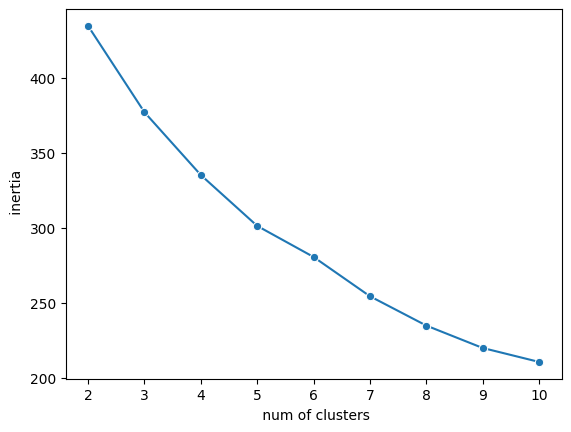

In [25]:
elbow = sns.lineplot(x= num_cluster, y = inertia, marker = 'o')
elbow.set_xlabel(" num of clusters")
elbow.set_ylabel(" inertia")

In [26]:
def Kmean_silscore(num_cluster, x_val):
    sil_score = []
    for i in num_cluster:
        kms = KMeans(n_clusters = i, random_state = 42)
        kms.fit(x_val)
        sil_score.append(silhouette_score(x_val, kms.labels_))
    return sil_score

sil_score = Kmean_silscore(num_cluster, X2)
sil_score

[np.float64(0.4927304616713888),
 np.float64(0.43259848143939467),
 np.float64(0.4020025186246455),
 np.float64(0.3998578894841472),
 np.float64(0.3964916122399439),
 np.float64(0.380668758798132),
 np.float64(0.3258866372615515),
 np.float64(0.3390951200956753),
 np.float64(0.34737584725476617)]

Text(0, 0.5, ' silhouette_score')

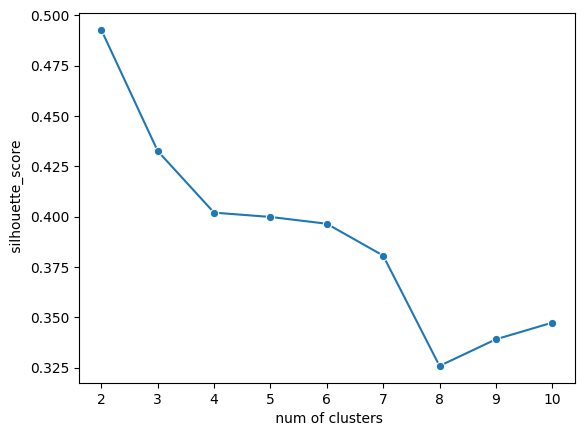

In [27]:
elbow = sns.lineplot(x= num_cluster, y = sil_score, marker = 'o')
elbow.set_xlabel(" num of clusters")
elbow.set_ylabel(" silhouette_score")

In [28]:
kms_cluster = KMeans(n_clusters=2, random_state=42)
kms_cluster.fit(X2)

KMeans(n_clusters=2, random_state=42)

In [29]:
analysis_set2.columns

Index(['player_id', 'affluent_loss_prone', 'chase_addict',
       'impulsive_behaviour_flag', 'spike_inflation_%', 'age_classification',
       'selfexc_history', 'latenight_session%', 'sum_net_result',
       'deposit_amount'],
      dtype='object')

In [30]:
analysis_set2["cluster"] = kms_cluster.labels_
analysis_set2.groupby(by =['cluster','chase_addict','impulsive_behaviour_flag','age_classification','affluent_loss_prone','selfexc_history']).size()

cluster  chase_addict  impulsive_behaviour_flag  age_classification  affluent_loss_prone  selfexc_history
0        1             0                         1                   1                    0                  8
                                                                                          1                  3
                                                                                          2                  3
                                                                                          3                  1
                       2                         1                   1                    0                  2
                                                                                          1                  1
                       3                         1                   1                    0                  1
         2             0                         1                   1                    0                  3
      

C:\Users\asingh\AppData\Local\Temp\ipykernel_15648\1690675442.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor = (1.3,1.0))


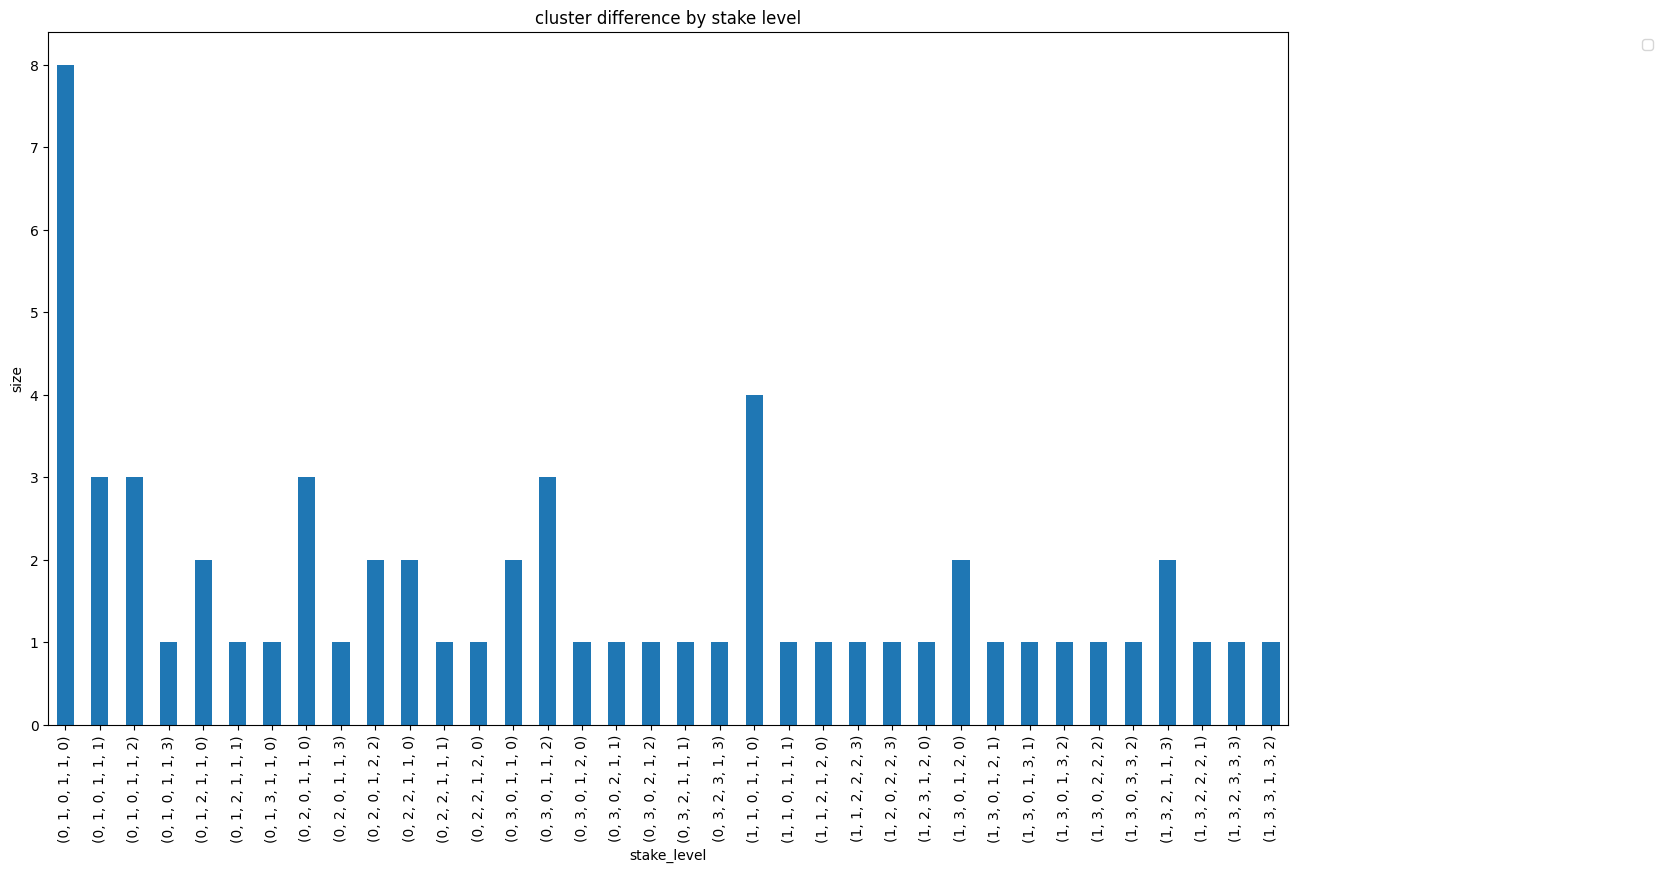

In [31]:
analysis_set2.groupby(by = ['cluster','chase_addict','impulsive_behaviour_flag','age_classification','affluent_loss_prone','selfexc_history']).size().plot.bar(title = "cluster difference by stake level",
                                                                                  figsize = (16,9),
                                                                                  ylabel ='size',
                                                                                  xlabel = 'stake_level')
plt.legend(bbox_to_anchor = (1.3,1.0))

In [32]:
analysis_set2[(analysis_set2["chase_addict"] == 3) & (analysis_set2["impulsive_behaviour_flag"] == 2) & (analysis_set2["age_classification"] == 3) & (analysis_set2["affluent_loss_prone"] == 1) & (analysis_set2["selfexc_history"] == 3)]

,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%,sum_net_result,deposit_amount,cluster
3,1004,1,3,2,53.57,3,3,36.64,-1756,2589,0


In [59]:
analysis_set[analysis_set["player_id"] == 1004] 

,player_id,gender,deposit_amount,avg_total_hands/session,sum_net_result,avg_buyin_amount,avg_session_intensity,avg_duration_hour,chaseloss_count,total_rounds,total_loss%,income_levels,age_class,mean_mask,spike_inflation,sum_latenight_hrs,sum_session_count,latenight_session%
3,1004,1,2589,38,-1756,318,1,6,12,28,64.29,1,3,5,15,48,131,36.64


# Random Forest 

0.3602745615113804


<Axes: >

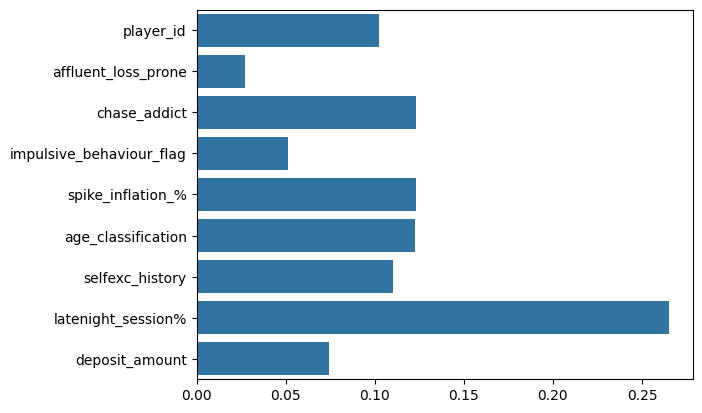

In [34]:
y = analysis_set2["sum_net_result"]
X = analysis_set2.drop(columns={'sum_net_result','cluster'},axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=50, max_features=3, max_depth=20, oob_score=True)
rf.fit(X_train,y_train)
print(rf.oob_score_)
sns.barplot(x = rf.feature_importances_ , y= rf.feature_names_in_)
# 0.20646386562445185

In [35]:
pred_chase = rf.predict(X_test)
import math
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(y_true= y_test, y_pred = pred_chase)
print(f"mean_absolute_error is {mae}")

mse = mean_squared_error(y_true = y_test, y_pred= pred_chase)
rmse = math.sqrt(mse)
print(f"mean_squared_error is {rmse}")

#mean_absolute_error is 803.85
#mean_squared_error is 957.0505432838958

mean_absolute_error is 308.965
mean_squared_error is 365.4713504047433


In [36]:
df = analysis_set2.loc[y_test.index].copy()
df["predict"] = pred_chase
all_players = df["player_id"].unique()
#print("All players:", all_players)
addict = analysis_set2[analysis_set2["player_id"].isin(df["player_id"])]
addict

,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%,sum_net_result,deposit_amount,cluster
0,1001,1,1,0,52.38,1,2,32.61,-618,1128,0
5,1006,1,1,0,38.10,1,1,29.41,178,1103,0
12,1013,1,1,0,40.91,1,0,2.86,37,1142,0
13,1014,2,1,2,51.85,2,3,23.66,-294,5000,1
33,1034,1,3,2,53.85,1,3,24.64,-735,3316,1
36,1037,1,2,0,44.00,1,0,15.15,103,1678,0
45,1046,2,3,2,56.00,2,1,25.32,-534,3756,1
46,1047,2,3,0,50.00,2,2,34.62,-1012,3064,1
48,1049,1,2,0,31.58,1,0,0.00,-405,1551,0
50,1051,2,2,0,57.69,1,2,34.62,-750,2734,0


In [ ]:

def calculate_risk_score(row):
    score = 0
    
    # affluent_loss_prone: 1=0, 2=1, 3=2
    if row['affluent_loss_prone'] == 1:
        score += 0
    elif row['affluent_loss_prone'] == 2:
        score += 1
    elif row['affluent_loss_prone'] == 3:
        score += 2
    
    # chase_addict: 1=0, 2=1, 3=2
    if row['chase_addict'] == 1:
        score += 0
    elif row['chase_addict'] == 2:
        score += 1
    elif row['chase_addict'] == 3:
        score += 2
    
    # impulsive_behaviour_flag: 0=0, 1=1, 2=2
    if row['impulsive_behaviour_flag'] == 2:
        score += 1
    elif row['impulsive_behaviour_flag'] == 3:
        score += 2
    else:
        score += row['impulsive_behaviour_flag']
    
    # spike_inflation_%: <40=0, 40-50=1, >50=2
    if row['spike_inflation_%'] < 40:
        score += 0
    elif 40 <= row['spike_inflation_%'] <= 60:
        score += 1
    else:
        score += 2
    
    # selfexc_history: 0=0, 1=1, 2=1, 3=2
    if row['selfexc_history'] == 1:
        score += 1
    elif row['selfexc_history'] == 2:
        score += 1
    elif row['selfexc_history'] == 3:
        score += 2
    else:
        score += row['selfexc_history']
    
    # latenight_session%: <10=0, 10-25=1, >25=2
    if row['latenight_session%'] < 10:
        score += 0
    elif 10 <= row['latenight_session%'] <= 25:
        score += 1
    else:
        score += 2
    
    # sum_net_result: positive=0, negative>-500=1, <=-500=2
    if row['sum_net_result'] > 0:
        score += 0
    elif row['sum_net_result'] > -500:
        score += 1
    else:
        score += 2
    
    # deposit_amount: <2000=0, 2000-4000=1, >4000=2
    if row['deposit_amount'] < 2000:
        score += 0
    elif 2000 <= row['deposit_amount'] <= 4000:
        score += 1
    else:
        score += 2
    
        
    # Calculate percentage (max score is 17) Total possible score: 0-17 (sum of max scores: 3+3+2+2+3+2+2+2+1).
    risk_percentage = (score / 17) * 100
    return round(risk_percentage, 2)

analysis_set2['risk_percentage'] =analysis_set2.apply(calculate_risk_score, axis=1)
az = analysis_set2.sort_values(by='risk_percentage', ascending =False)
az.drop('cluster',axis=1,inplace = True)
az


,player_id,affluent_loss_prone,chase_addict,impulsive_behaviour_flag,spike_inflation_%,age_classification,selfexc_history,latenight_session%,sum_net_result,deposit_amount,risk_percentage
28,1029,3,3,2,60.00,3,3,43.38,-2121,5000,88.24
3,1004,1,3,2,53.57,3,3,36.64,-1756,2589,70.59
35,1036,3,3,3,68.18,1,2,9.76,-810,3242,70.59
42,1043,3,3,0,48.28,3,2,45.11,-625,4245,70.59
45,1046,2,3,2,56.00,2,1,25.32,-534,3756,70.59
33,1034,1,3,2,53.85,1,3,24.64,-735,3316,64.71
57,1058,3,3,0,60.87,1,1,9.52,-1161,4816,64.71
53,1054,2,2,0,47.83,2,3,29.17,-653,4657,64.71
8,1009,1,3,2,52.17,1,3,13.33,-545,3087,64.71
11,1012,3,3,0,45.83,1,2,31.25,-246,5000,64.71


# XGBoost 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)


<Axes: >

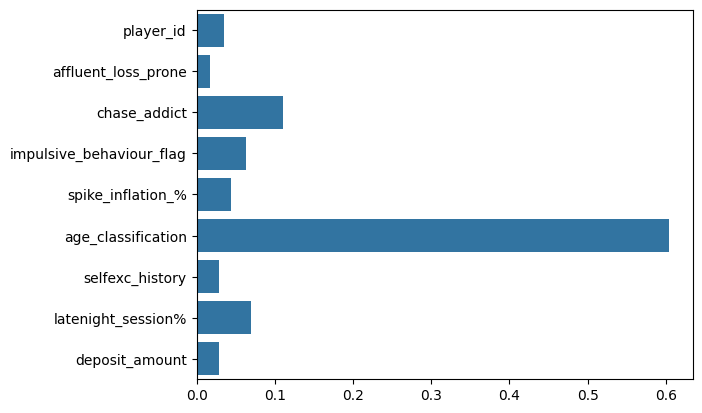

In [38]:
from xgboost import XGBRegressor
y3 = analysis_set2["sum_net_result"]
X3 = analysis_set2.drop(columns={'sum_net_result','cluster'},axis = 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3, y3, test_size = 0.20, random_state=42)
xgb_reg = XGBRegressor(max_depth = 4, min_child_weight = 3, learning_rate = 0.1, n_estimators = 50)
xg = xgb_reg.fit(X_train2,y_train2)
print(xg)
sns.barplot(x = xg.feature_importances_, y = xg.feature_names_in_)

In [39]:
pred_chase2= xg.predict(X_test2)
mae2 = mean_absolute_error(y_true = y_test2, y_pred = pred_chase2)
print(f" mean absolute error is : {mae2}")

mse2 = mean_squared_error(y_true = y_test2, y_pred = pred_chase2)
rmse2 = math.sqrt(mse2)
print(f" mean square error is : {rmse2}")
# mean absolute error is : 769.7705078125
# mean square error is : 841.74925749893


 mean absolute error is : 361.5050048828125
 mean square error is : 404.989293839973


<Axes: xlabel='sum_net_result', ylabel='sum_net_result'>

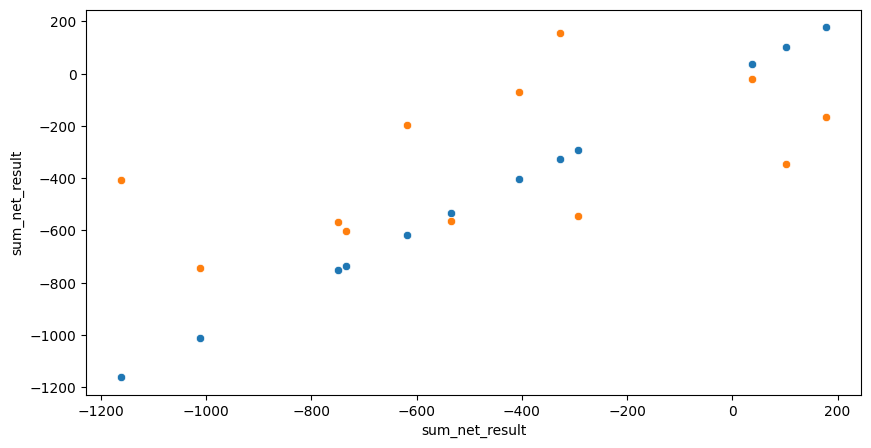

In [40]:
fix, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(x = y_test, y =y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_chase, ax = ax)

<Axes: xlabel='sum_net_result', ylabel='sum_net_result'>

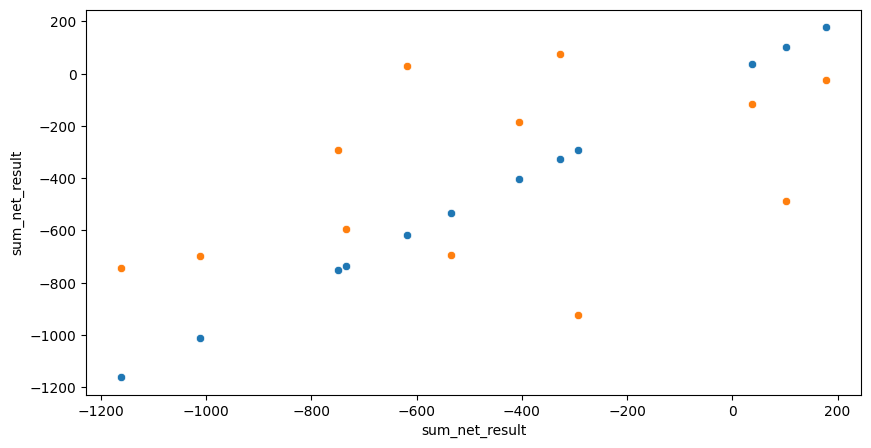

In [41]:
fix, ax = plt.subplots(figsize = (10,5))

sns.scatterplot(x = y_test2, y =y_test2, ax = ax)
sns.scatterplot(x = y_test2, y = pred_chase2, ax = ax)

In [42]:
cross_val_score(RandomForestRegressor(),X,y)
# array([0.49295289, 0.30834113, 0.2989277 , 0.31911112, 0.39980559]) - deposit_amount

array([ 0.21954093,  0.35345308,  0.59038838, -0.28614192, -0.32329662])

In [43]:
cross_val_score(XGBRegressor(),X3,y3)
# array([ 0.71478629,  0.40907496,  0.19476277, -0.2913816 ,  0.25790519]) - deposit_amount

array([ 0.06472778, -0.3145721 ,  0.4320749 , -0.677495  , -0.35514534])

In [44]:
score = cross_val_score(KMeans(n_clusters = 2,n_init=10,random_state=42),x_scale,cv = 3)
print(np.mean(score))
print(np.std(score))
score

-180.7626051185495
19.410753071401597


array([-201.15310177, -154.65080136, -186.48391222])

In [45]:
pred_chase

array([-197.22, -165.4 , -347.38, -562.62, -546.02,  156.22, -603.42,
        -70.9 ,  -20.86, -406.58, -745.46, -566.34])